Episode: 0, Step: 400, Counter: 0, Attached_counter: 0, Total reward: -3935.357421875, final state: tensor([-0.1728,  0.5862,  0.4640,  0.1973]), 


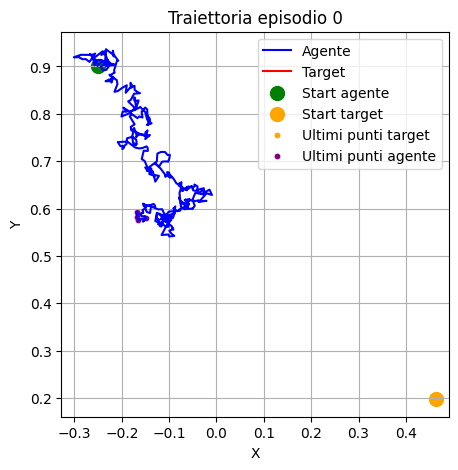

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from environment import TrackingEnv

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 1600
NUM_NEURONS = 256   #128
LR_CRITIC = 0.0005
LR_ACTOR = 0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOPPING_EPISODES = 50
ENTROPY_COEFF = 0.01

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = torch.cat([values, torch.tensor([0], dtype=values.dtype, device=values.device)])  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float)

def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        G = reward + gamma * G * (1 - done)  # Reset if episode ended
        returns.insert(0, G)
    return returns

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()

        self.noise_std = 0.02
        
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        
        # Output per la media (mu)
        self.mu_layer = nn.Linear(NUM_NEURONS, action_dim)
        
        # Output per la deviazione standard (log_sigma)
        self.log_sigma_layer = nn.Linear(NUM_NEURONS, action_dim)

    def add_noise_to_target(self, state):
        state = state.clone()
        if state.dim() == 1:
            state[2:4] += torch.normal(0.0, self.noise_std, size=(2,), device=state.device)
        else:
            state[:, 2:4] += torch.normal(0.0, self.noise_std, size=state[:, 2:4].shape, device=state.device)
        return state


    def forward(self, state):#, exploration_term):

        #state = self.add_noise_to_target(state)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Media delle azioni
        mu = self.mu_layer(x)
        
        # Deviazione standard (softplus per garantire positività)
        log_sigma = self.log_sigma_layer(x)
        sigma = F.softplus(log_sigma) + 1e-5 # 1e-5 per evitare log(0)
        #sigma = F.softplus(log_sigma) + exploration_term + 1e-5 # 1e-5 per evitare log(0)

        return mu, sigma

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        mu, sigma = self.actor.forward(state)#, exploration_term)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.rsample()  # Usa reparametrization trick per il backprop
        log_prob = dist.log_prob(action).sum(dim=-1)  # Somma log-prob per dimensione azione
        return action.detach(), log_prob

    def store_transition(self, transition):
        self.buffer.append(transition)



    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):

    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]
    #     #next_pos = torch.tensor(next_pos, dtype=torch.float32)

        # to_target = F.normalize(target - pos, dim=0)          # direzione ideale
        # action_dir = F.normalize(action, dim=0)               # direzione dell’azione
        # direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1

        # # Distanze
        # dist_before = torch.norm(pos - target)
        # dist_after = torch.norm(next_pos - target)
        # progress = dist_before - dist_after
        
        # step_penalty = 0.01 * step # 0.01

        # #Se raggiunge il target
        # if dist_after < tolerance:
        #    reward = 500 - 5 * step #if step > 100 else 500
        #    #reward = 500
        # else:
        #    #reward = "quanto mi avvicino" + "quanto vado nella direzione giusta"
        #    reward = 2 * progress + 5 * direction_reward  # pesi da tarare 2 5

        # if rimbalzato:
        #    reward += -5

        # return reward - step_penalty
    

    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
        pos = state[:2]
        target = state[2:4]              # target(t)
        next_pos = next_state[:2]        # agent(t+1)

        to_target = F.normalize(target - pos, dim=0)
        action_dir = F.normalize(action, dim=0)
        direction_reward = torch.dot(action_dir, to_target)

        dist_before = torch.norm(pos - target)
        dist_after = torch.norm(next_pos - target)  # sempre verso target(t)
        progress = dist_before - dist_after

        step_penalty = 0.05 * step
        reward = 0

        # Calcola la distanza rispetto al target precedente
        dist_to_target = torch.norm(next_pos - target)

        if dist_to_target < tolerance:
            # Raggiunto o mantenuto nella soglia rispetto al target precedente
            reward += 2                         # base reward
            reward += 0.5 * attached_counter    # più tempo resta vicino → più reward
        else:
            # Fase di inseguimento
            reward += 2 * progress + 4 * direction_reward

            if progress < 0:
                reward += 3 * progress  # penalizzazione per allontanamento

        if rimbalzato:
            reward -= 5

        return reward - step_penalty

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
    #     return - torch.norm(next_state[:2] - state[2:4]) - 0.01 * step + 0.5 * attached_counter
        
    
    def update(self):
        torch.autograd.set_detect_anomaly(True)
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.stack(states)
        actions = torch.stack(actions).float()
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards, values.detach(), dones)
        returns = compute_returns(rewards, dones)  # Compute Monte Carlo returns
        returns = torch.tensor(returns, dtype=torch.float32)
        
        for _ in range(K_EPOCH):
            means, stds = self.actor(states)
            dist = torch.distributions.Normal(means, stds)
            entropy = dist.entropy().sum(dim=-1).mean()  # media sull’intero batch
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean() - ENTROPY_COEFF * entropy
            values_pred =self.critic(states).squeeze()
            value_loss = F.mse_loss(values_pred, returns)

            total_loss = policy_loss + value_loss

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            #policy_loss.backward()
            #value_loss.backward()
            total_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        self.buffer.clear()

def train_ppo(env=None, num_episodes=2000):
    if env is None:
        env = TrackingEnv()
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    success_history = []
    counter = 0
    tolerance = 0.02 #0.05
    
    for episode in range(num_episodes):
        #target = np.random.uniform(-0.05, 0.05, size=(2,))    # -0.5, 0.5 non convergeva in 4000 episodi
        #target = torch.tensor(target, dtype=torch.float32)
        state, _ = env.reset()#(target=target)
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        trajectory = []
        target_trajectory = []
        step = 0
        attached_counter = 0
        
        while not done:
            step += 1
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:].detach().numpy())
            action, log_prob = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4])<tolerance or truncated:
               done = True
            # if torch.norm(next_state[:2] - target_trajectory[-1])<tolerance:
            #     attached_counter += 1
            
            reward = agent.reward_function(state, action, next_state, step, tolerance, rimbalzato, attached_counter)

            #if truncated or (torch.norm(next_state[:2]-target_trajectory[-1])>tolerance and attached_counter > 0):
            #    done = True

            #done = done or truncated

            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward
        
        if torch.norm(next_state[:2] - next_state[2:4])<tolerance:
        #if attached_counter > 10:
            counter += 1
            success_history.append(1)
            # PLOTTING TRAIETTORIA A SUCCESSO
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            print(f"SUCCESSO Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}")
            
            if counter % 10 == 0:

                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
                plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
                plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
                plt.scatter(*target_trajectory[0], color='yellow', label='Start target', s=100)
                plt.scatter(*target_trajectory[-1], color='red', label='End agente', s=100)
                # Stampa gli ultimi 5 punti della traiettoria del target
                plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi punti target', s=10)
                # Stampa l'ultimo punto della traiettoria dell'agente
                plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi punti agente', s=10)
                plt.title(f"Traiettoria episodio {episode}, SUCCESSO")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()

        else:
            success_history.append(0)

        reward_history.append(total_reward)

        if episode % 10 == 0:
            #print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}, ")

        #if attached_counter > 10:
            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}, ")

            trajectory = np.array(trajectory)
            #target = next_state[2:4].detach().numpy()  # x_target, y_target
            target_trajectory = np.array(target_trajectory)

            plt.figure(figsize=(5, 5))
            plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
            plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], linestyle='-', label="Target", color='red')
            plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
            plt.scatter(*target_trajectory[0], color='orange', label='Start target', s=100)
            # Stampa gli ultimi 5 punti della traiettoria del target
            plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi punti target', s=10)
                # Stampa l'ultimo punto della traiettoria dell'agente
            plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi punti agente', s=10)
            plt.title(f"Traiettoria episodio {episode}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.grid()
            plt.axis('equal')
            plt.show()

        
        #if len(reward_history)>EARLY_STOPPING_EPISODES and all(s == 1 for s in success_history[-EARLY_STOPPING_EPISODES:]):
        #    break
        
        #if len(reward_history) > EARLY_STOPPING_EPISODES and np.mean(reward_history[-EARLY_STOPPING_EPISODES:]) > 90:
        #    print(f"Early stopping at episode {episode}")
        #    break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


[Episode 0] Steps: 54, Final distance: 0.0156


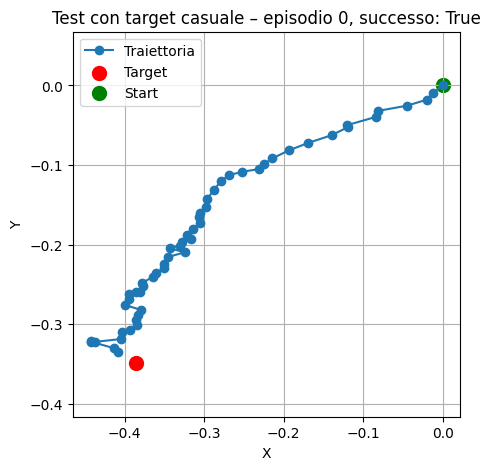

[Episode 1] Steps: 43, Final distance: 0.0187
[Episode 2] Steps: 38, Final distance: 0.0150
[Episode 3] Steps: 56, Final distance: 0.0184
[Episode 4] Steps: 57, Final distance: 0.0111
[Episode 5] Steps: 61, Final distance: 0.0148
[Episode 6] Steps: 74, Final distance: 0.0180
[Episode 7] Steps: 17, Final distance: 0.0170
[Episode 8] Steps: 74, Final distance: 0.0186
[Episode 9] Steps: 54, Final distance: 0.0191
[Episode 10] Steps: 27, Final distance: 0.0073


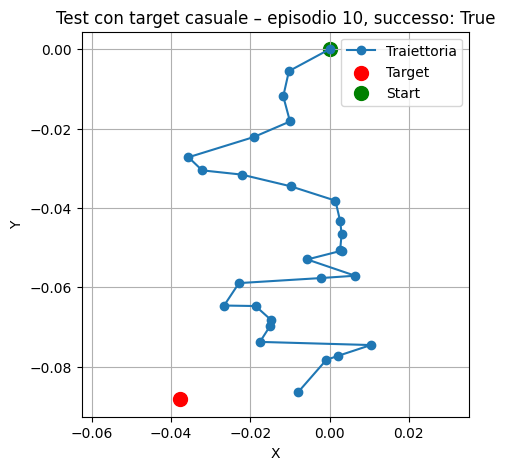

[Episode 11] Steps: 59, Final distance: 0.0192
[Episode 12] Steps: 52, Final distance: 0.0106
[Episode 13] Steps: 34, Final distance: 0.0195
[Episode 14] Steps: 63, Final distance: 0.0196
[Episode 15] Steps: 50, Final distance: 0.0176
[Episode 16] Steps: 37, Final distance: 0.0196
[Episode 17] Steps: 24, Final distance: 0.0167
[Episode 18] Steps: 75, Final distance: 0.0192
[Episode 19] Steps: 400, Final distance: 0.1503
[Episode 20] Steps: 31, Final distance: 0.0164


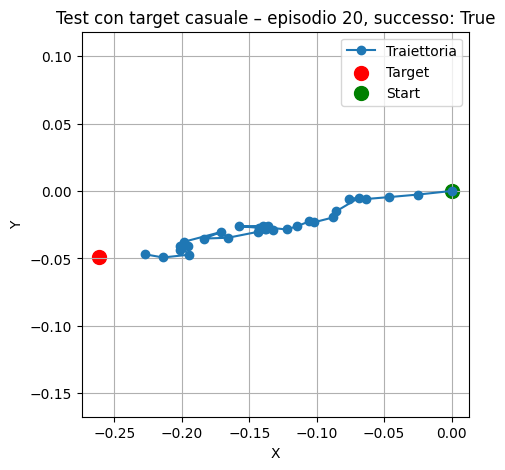

[Episode 21] Steps: 55, Final distance: 0.0191
[Episode 22] Steps: 400, Final distance: 0.0551
[Episode 23] Steps: 81, Final distance: 0.0188
[Episode 24] Steps: 16, Final distance: 0.0168
[Episode 25] Steps: 38, Final distance: 0.0179
[Episode 26] Steps: 30, Final distance: 0.0126
[Episode 27] Steps: 63, Final distance: 0.0163
[Episode 28] Steps: 29, Final distance: 0.0145
[Episode 29] Steps: 60, Final distance: 0.0185
[Episode 30] Steps: 37, Final distance: 0.0195


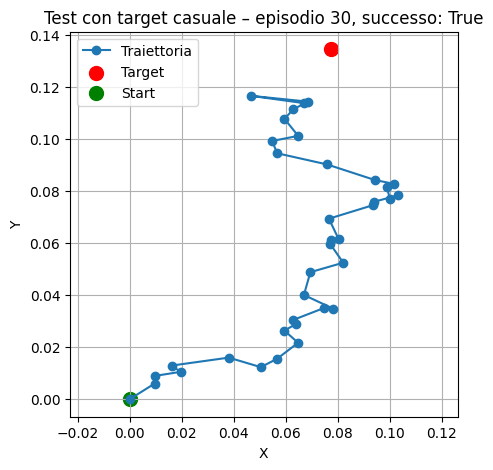

[Episode 31] Steps: 24, Final distance: 0.0186
[Episode 32] Steps: 188, Final distance: 0.0182
[Episode 33] Steps: 50, Final distance: 0.0165
[Episode 34] Steps: 41, Final distance: 0.0063
[Episode 35] Steps: 62, Final distance: 0.0118
[Episode 36] Steps: 400, Final distance: 0.0301
[Episode 37] Steps: 59, Final distance: 0.0167
[Episode 38] Steps: 82, Final distance: 0.0088
[Episode 39] Steps: 64, Final distance: 0.0192
[Episode 40] Steps: 40, Final distance: 0.0145


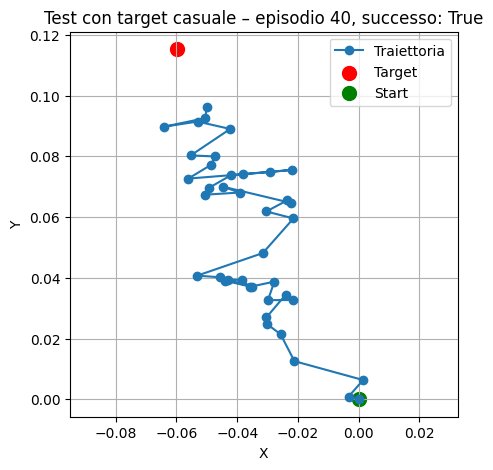

[Episode 41] Steps: 75, Final distance: 0.0192
[Episode 42] Steps: 36, Final distance: 0.0198
[Episode 43] Steps: 27, Final distance: 0.0175
[Episode 44] Steps: 400, Final distance: 0.0990
[Episode 45] Steps: 51, Final distance: 0.0197
[Episode 46] Steps: 32, Final distance: 0.0141
[Episode 47] Steps: 84, Final distance: 0.0151
[Episode 48] Steps: 32, Final distance: 0.0178
[Episode 49] Steps: 66, Final distance: 0.0132
[Episode 50] Steps: 61, Final distance: 0.0180


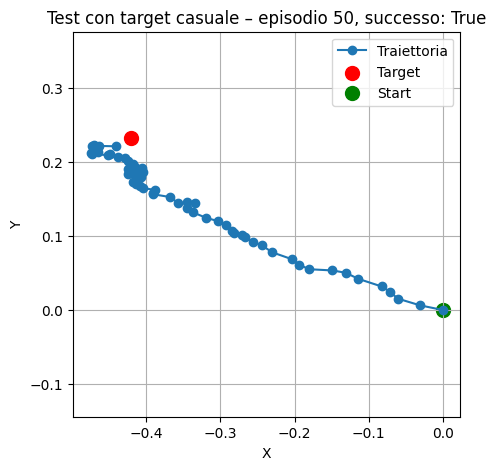

[Episode 51] Steps: 75, Final distance: 0.0159
[Episode 52] Steps: 49, Final distance: 0.0188
[Episode 53] Steps: 38, Final distance: 0.0132
[Episode 54] Steps: 55, Final distance: 0.0149
[Episode 55] Steps: 400, Final distance: 0.0774
[Episode 56] Steps: 55, Final distance: 0.0196
[Episode 57] Steps: 56, Final distance: 0.0168
[Episode 58] Steps: 400, Final distance: 0.1475
[Episode 59] Steps: 46, Final distance: 0.0087
[Episode 60] Steps: 43, Final distance: 0.0177


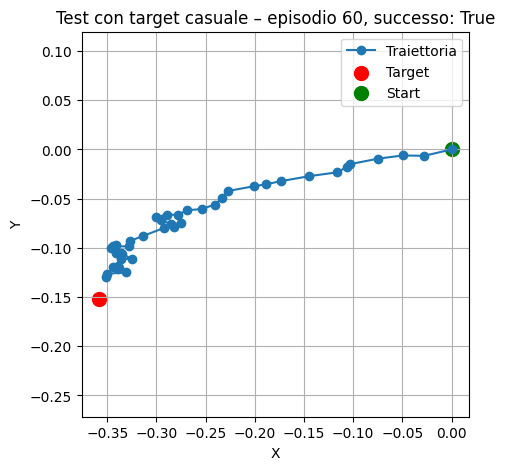

[Episode 61] Steps: 47, Final distance: 0.0188
[Episode 62] Steps: 58, Final distance: 0.0183
[Episode 63] Steps: 50, Final distance: 0.0179
[Episode 64] Steps: 94, Final distance: 0.0186
[Episode 65] Steps: 58, Final distance: 0.0152
[Episode 66] Steps: 32, Final distance: 0.0125
[Episode 67] Steps: 69, Final distance: 0.0130
[Episode 68] Steps: 73, Final distance: 0.0161
[Episode 69] Steps: 77, Final distance: 0.0195
[Episode 70] Steps: 35, Final distance: 0.0145


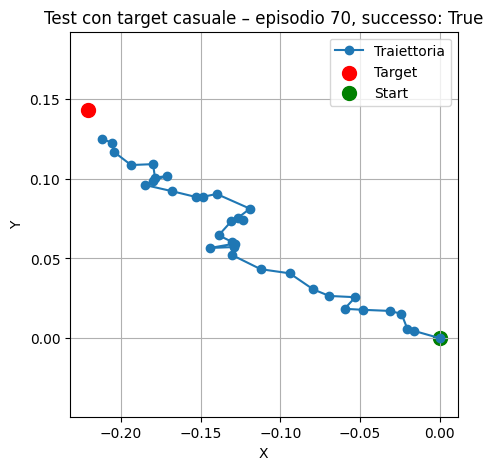

[Episode 71] Steps: 19, Final distance: 0.0194
[Episode 72] Steps: 42, Final distance: 0.0192
[Episode 73] Steps: 55, Final distance: 0.0156
[Episode 74] Steps: 61, Final distance: 0.0199
[Episode 75] Steps: 48, Final distance: 0.0101
[Episode 76] Steps: 44, Final distance: 0.0173
[Episode 77] Steps: 64, Final distance: 0.0140
[Episode 78] Steps: 88, Final distance: 0.0120
[Episode 79] Steps: 55, Final distance: 0.0154
[Episode 80] Steps: 62, Final distance: 0.0188


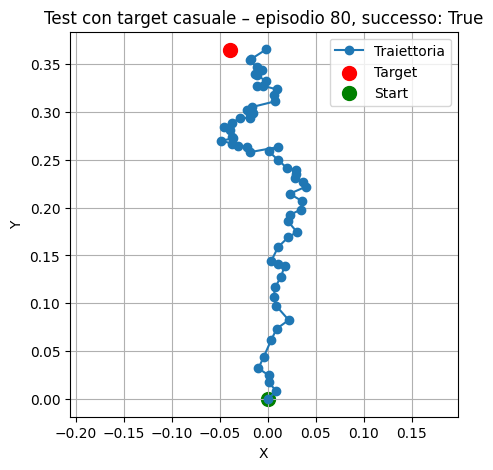

[Episode 81] Steps: 24, Final distance: 0.0149
[Episode 82] Steps: 71, Final distance: 0.0155
[Episode 83] Steps: 90, Final distance: 0.0198
[Episode 84] Steps: 66, Final distance: 0.0119
[Episode 85] Steps: 53, Final distance: 0.0171
[Episode 86] Steps: 73, Final distance: 0.0172
[Episode 87] Steps: 52, Final distance: 0.0149
[Episode 88] Steps: 101, Final distance: 0.0124
[Episode 89] Steps: 30, Final distance: 0.0134
[Episode 90] Steps: 400, Final distance: 0.0967
[Episode 91] Steps: 60, Final distance: 0.0136
[Episode 92] Steps: 19, Final distance: 0.0200
[Episode 93] Steps: 58, Final distance: 0.0162
[Episode 94] Steps: 41, Final distance: 0.0145
[Episode 95] Steps: 54, Final distance: 0.0135
[Episode 96] Steps: 40, Final distance: 0.0090
[Episode 97] Steps: 85, Final distance: 0.0039
[Episode 98] Steps: 59, Final distance: 0.0165
[Episode 99] Steps: 81, Final distance: 0.0169
Media delle distanze finali: 0.0214, numero di successi: 93


In [3]:
def test_agent_with_random_targets(agent, env=None, num_episodes=100, target_sampler=None, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()

    final_distances = []
    success_counter = 0

    for ep in range(num_episodes):
        # Genera un target casuale (es. all’interno di uno spazio 2D limitato)
        if target_sampler:
            target = target_sampler()
            target = torch.tensor(target, dtype=torch.float32)
        else:
            target = np.random.uniform(low=-0.5, high=0.5, size=(2,))  # Default sampler
            target = torch.tensor(target, dtype=torch.float32)

        state, _ = env.reset(target=target)
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            action, _ = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        trajectory = np.array(trajectory)
        final_dist = np.linalg.norm(state[:2] - state[2:4])
        final_distances.append(final_dist)
        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}")

        success = False

        if final_dist < tolerance:
            success = True
            success_counter += 1


        if success and ep % 10 == 0:
            plt.figure(figsize=(5, 5))
            plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
            plt.scatter(*state[2:4], color='red', label='Target', s=100)
            plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
            plt.title(f"Test con target casuale – episodio {ep}, successo: {success}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.grid()
            plt.axis('equal')
            plt.show()

    env.close()

    print(f"Media delle distanze finali: {np.mean(final_distances):.4f}, numero di successi: {success_counter}")

def target_sampler():
    # Genera target in un quadrato [-1, 1] x [-1, 1]
    return np.random.uniform(low=-0.5, high=0.5, size=(2,))


test_agent_with_random_targets(trained_agent, target_sampler=target_sampler)